# Vanilla LSTM implementation from scratch 

## 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import uniform

## 1. Data Preparation

Our dataset is J.K. Rowling's Harry Potter and the Philosopher's Stone. 

I chose this text as the characteristic context and semantic structures present in the abundant dialogue, will help with evaluating the quality of results (also a huge HP fan...)

In [2]:
data = open('Downloads/HP1.txt').read().lower()

In [3]:
chars = set(data)
vocab_size = len(chars)

print('data has %d characters, %d unique' % (len(data), vocab_size))

data has 442744 characters, 54 unique


In [4]:
# creating dictionaries for mapping chars to ints and vice versa
char_to_idx = {w: i for i,w in enumerate(chars)}
idx_to_char = {i: w for i,w in enumerate(chars)}

## 2. Define the model

In [1]:
class LSTM:
    def __init__(self, char_to_idx, idx_to_char, vocab_size, num_hidden_units=100, 
                 seq_len=25, epochs=100, learning_rate=0.002, beta1=0.9, beta2=0.999):
        """
        Implementation of simple character-level LSTM using Numpy
        """
        self.char_to_idx = char_to_idx  # dictionary that maps characters in the vocabulary to an index
        self.idx_to_char = idx_to_char  # dictionary that maps indices to unique characters in the vocabulary
        
        self.vocab_size = vocab_size # number of unique characters in the training data
        self.n_h = num_hidden_units # desirable number of units in the hidden layer
        self.seq_len = seq_len # number of characters that will be fed to the LSTM in each batch (also number of time steps)
        
        self.epochs = epochs # number of training iterations
        self.lr = learning_rate
        self.beta1 = beta1 # 1st momentum parameter
        self.beta2 = beta2 # 2nd momentum parameter
    
        #---INITIALISE WEIGHTS AND BIASES---
        self.params = {}

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * \
                            (1.0/np.sqrt(self.vocab_size + self.n_h))
        self.params["bf"] = np.ones((self.n_h,1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * \
                            (1.0/np.sqrt(self.vocab_size + self.n_h))
        self.params["bi"] = np.zeros((self.n_h,1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * \
                            (1.0/np.sqrt(self.vocab_size + self.n_h))
        self.params["bc"] = np.zeros((self.n_h,1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * \
                            (1.0/np.sqrt(self.vocab_size + self.n_h))
        self.params["bo"] = np.zeros((self.n_h ,1))

        # output
        self.params["Wv"] = np.random.randn(self.vocab_size, self.n_h) * \
                            (1.0/np.sqrt(self.vocab_size))
        self.params["bv"] = np.zeros((self.vocab_size ,1))

        #---INITIALISE GRADIENTS AND ADAM PARAMETERS---
        self.grads = {}
        self.adam_params = {}

        for key in self.params:
            self.grads["d"+key] = np.zeros_like(self.params[key])
            self.adam_params["m"+key] = np.zeros_like(self.params[key])
            self.adam_params["v"+key] = np.zeros_like(self.params[key])
            
        self.smooth_loss = -np.log(1.0 / self.vocab_size) * self.seq_len  # smoothing out loss as batch SGD is noisy
        return
    
    def sigmoid(self, x):
        """
        Smoothes out values in the range of [0,1]
        """
        return 1 / (1 + np.exp(-x))

    def dsigmoid(self, y):
        """
        Computes the gradient of sigmoid(x), but takes as an input
        y = sigmoid(x) instead of x
        """
        return y * (1 - y)

    def dtanh(self, y):
        """
        Computes the gradient of tanh(x), but takes as an input
        y = tanh(x) instead of x
        """
        return 1 - y**2

    def softmax(self, x):
        """
        Normalizes output into a probability distribution
        """
        e_x = np.exp(x - np.max(x)) # max value is subtracted for numerical stability
        return e_x / np.sum(e_x)
    
    def clip_grads(self):
        """
        Limits the magnitude of gradients to avoid exploding gradients
        """
        for key in self.grads:
            np.clip(self.grads[key], -5, 5, out=self.grads[key])
        return
    
    def reset_grads(self):
        """
        Resets gradients to zero before each backpropagation
        """
        for key in self.grads:
            self.grads[key].fill(0)
        return
            
    def update_params(self, batch_num):
        """
        Updates parameters with Adam
        """     
        for key in self.params:
            self.adam_params["m"+key] = self.adam_params["m"+key] * self.beta1 + \
                                        (1 - self.beta1) * self.grads["d"+key]
            self.adam_params["v"+key] = self.adam_params["v"+key] * self.beta2 + \
                                        (1 - self.beta2) * self.grads["d"+key]**2

            m_correlated = self.adam_params["m" + key] / (1 - self.beta1**batch_num)
            v_correlated = self.adam_params["v" + key] / (1 - self.beta2**batch_num) 
            # add small value to denominator for numerical stability
            self.params[key] -= self.lr * m_correlated / (np.sqrt(v_correlated + 1e-8)) 
        return
            
    def sample(self, h_prev, c_prev, first_char_idx, sentence_length):
        """
        Outputs a sample sequence from the model
        """
        x = np.zeros((self.vocab_size, 1))
        x[first_char_idx] = 1
        s = ""

        h = h_prev
        c = c_prev

        for t in range(sentence_length):
            y_pred, _, h, _, c, _, _, _, _ = self.forward_step(x, h, c)        

            idx = np.random.choice(range(self.vocab_size), p=y_pred.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1

            char = self.idx_to_char[idx]
            s += char
        return s
    
    
    def forward_step(self, x, h_prev, c_prev):
        """
        Implements the forward propagation for one time step
        """
        z = np.row_stack((h_prev, x))

        f = self.sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])
        i = self.sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])
        c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])

        c = f * c_prev + i * c_bar
        o = self.sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])
        h = o * np.tanh(c)

        v = np.dot(self.params["Wv"], h) + self.params["bv"]
        y_pred = self.softmax(v)

        return y_pred, v, h, o, c, c_bar, i, f, z
    
    
    def backward_step(self, y, y_pred, dh_next, dc_next, c_prev, z, f, 
                            i, c_bar, c, o, h):
        """
        Implements the backward propagation for one time step
        """
        dv = np.copy(y_pred)
        dv[y] -= 1

        self.grads["dWv"] += np.dot(dv, h.T)
        self.grads["dbv"] += dv

        dh = np.dot(self.params["Wv"].T, dv)
        dh += dh_next

        do = dh * np.tanh(c)
        do = self.dsigmoid(o) * do
        self.grads["dWo"] += np.dot(do, z.T)
        self.grads["dbo"] += do

        dc = np.copy(dc_next)
        dc += dh * o * self.dtanh(np.tanh(c))

        dc_bar = dc * i
        dc_bar = self.dtanh(c_bar) * dc_bar
        self.grads["dWc"] += np.dot(dc_bar, z.T)
        self.grads["dbc"] += dc_bar

        di = dc * c_bar
        di = self.dsigmoid(i) * di 
        self.grads["dWi"] += np.dot(di, z.T)
        self.grads["dbi"] += di

        df = dc * c_prev
        df = self.dsigmoid(f) * df
        self.grads["dWf"] += np.dot(df, z.T)
        self.grads["dbf"] += df

        dz = (np.dot(self.params["Wf"].T, df)
             + np.dot(self.params["Wi"].T, di)
             + np.dot(self.params["Wc"].T, dc_bar)
             + np.dot(self.params["Wo"].T, do))

        dh_prev = dz[:self.n_h, :]
        dc_prev = f * dc
        return dh_prev, dc_prev
    
    
    def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
        """
        Implements the forward and backward propagation for one batch
        """
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_pred, v, h = {}, {}, {}

        # Values at t - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len): #seq len
            x[t] = np.zeros((self.vocab_size, 1))
            x[t][x_batch[t]] = 1

            y_pred[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
            self.forward_step(x[t], h[t-1], c[t-1])

            loss += -np.log(y_pred[t][y_batch[t],0])

        self.reset_grads()

        dh_next = np.zeros_like(h[0])
        dc_next = np.zeros_like(c[0])

        for t in reversed(range(self.seq_len)):
            dh_next, dc_next = self.backward_step(y_batch[t], y_pred[t], 
                                                  dh_next, dc_next, c[t-1], 
                                                  z[t], f[t], i[t], c_bar[t], 
                                                  c[t], o[t], h[t]) 
        return loss, h[self.seq_len-1], c[self.seq_len-1]
    
    
    def gradient_check(self, x, y, h_prev, c_prev, num_checks=10, delta=1e-6):
        """
        Checks the magnitude of gradients against expected approximate values 
        """
        print("**********************************")
        print("Gradient check...\n")

        _, _, _ = self.forward_backward(x, y, h_prev, c_prev)
        grads_numerical = self.grads

        for key in self.params: 
            print("---------",key,"---------")
            test = True

            dims = self.params[key].shape
            grad_numerical = 0
            grad_analytical = 0

            for _ in range(num_checks): #sample 10 neurons

                idx = int(uniform(0, self.params[key].size))
                old_val = self.params[key].flat[idx]

                self.params[key].flat[idx] = old_val + delta
                J_plus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val - delta
                J_minus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val

                grad_numerical += (J_plus-J_minus)/(2*delta)
                grad_analytical += grads_numerical["d"+key].flat[idx]            

            grad_numerical /= num_checks
            grad_analytical /= num_checks

            rel_error = abs(grad_analytical-grad_numerical)/abs(grad_analytical+grad_numerical)

            if rel_error > 1e-2:
                if not (grad_analytical<1e-6 and grad_numerical<1e-6):
                    test = False
                    assert(test)

            print('Approximate: \t%e, Exact: \t%e =>  Error: \t%e'% (grad_numerical, grad_analytical, rel_error))
        print("\nTest successful!")
        print("**********************************\n")
        return
    
    
    def train(self, X, verbose = True):
        """
        Main method of the LSTM class where training takes place
        """
        J = [] 

        num_batches = len(X) // self.seq_len
        X_trimmed = X[: num_batches * self.seq_len]

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))

            for j in range(0, len(X_trimmed) - self.seq_len, self.seq_len):  
                # prepare batches
                x_batch = [self.char_to_idx[ch] for ch in X_trimmed[j : j+self.seq_len]]
                y_batch = [self.char_to_idx[ch] for ch in X_trimmed[j+1: j+self.seq_len+1]]                           
                
                # forward and back propagation
                loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)
                
                # calculate loss
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J.append(self.smooth_loss)
                
                # check gradients
                if epoch == 0 and j == 0:
                    self.gradient_check(x_batch, y_batch, h_prev, c_prev, 
                                        num_checks=10, delta=1e-7)
                
                # clip gradients
                self.clip_grads()
                
                # update parameters
                batch_num = epoch*self.epochs + j/self.seq_len + 1
                self.update_params(batch_num)

            # print out loss and sample output
            if verbose:
                print('Epoch:',epoch,'\tBatch:',j,"-",j+self.seq_len,
                      '\tLoss:',self.smooth_loss)

                s = self.sample(h_prev, c_prev, first_char_idx = x_batch[0], 
                                sentence_length = 250)
                print(s,"\n")

        plt.plot([i for i in range(len(J))], J)
        return J, self.params

In [6]:
model = LSTM(char_to_idx, idx_to_char, vocab_size)

**********************************
Gradient check...

--------- Wf ---------
Approximate: 	-4.551026e-05, Exact: 	-4.551690e-05 =>  Error: 	7.289734e-05
--------- bf ---------
Approximate: 	-2.138229e-03, Exact: 	-2.138277e-03 =>  Error: 	1.120486e-05
--------- Wi ---------
Approximate: 	-8.654411e-06, Exact: 	-8.645099e-06 =>  Error: 	5.382425e-04
--------- bi ---------
Approximate: 	-7.351268e-03, Exact: 	-7.351303e-03 =>  Error: 	2.386090e-06
--------- Wc ---------
Approximate: 	-3.832348e-03, Exact: 	-3.832382e-03 =>  Error: 	4.518190e-06
--------- bc ---------
Approximate: 	-1.071315e-01, Exact: 	-1.071316e-01 =>  Error: 	3.376136e-07
--------- Wo ---------
Approximate: 	-3.801262e-04, Exact: 	-3.800889e-04 =>  Error: 	4.904505e-05
--------- bo ---------
Approximate: 	5.570300e-04, Exact: 	5.569927e-04 =>  Error: 	3.348348e-05
--------- Wv ---------
Approximate: 	2.859510e-02, Exact: 	2.859515e-02 =>  Error: 	8.341811e-07
--------- bv ---------
Approximate: 	-4.281368e-01, Exact: 

Epoch: 23 	Batch: 442675 - 442700 	Loss: 30.64071084560715
s meft. 

yes...." 

he puppes asleep. 

"he see a dreamed beator, malfoy.! as you be before hands, it was a pain's after malfoy to ask playing breath, their back through herkiolt toward the hutwantion long out that much was trying aloty, i hand to c 

Epoch: 24 	Batch: 442675 - 442700 	Loss: 30.602526163975433
s oldgeor! wands. snape. the bead: these pain and belt. 

then sair umbrellow story. 

"no, all, climbed blacknor of ravenclaw goald between," he spacked. minus exactly of points, stammed opened...." harry had hearder; there dad, it was a hundred tha 

Epoch: 25 	Batch: 442675 - 442700 	Loss: 30.524278867585497
dns head start she was off looner for inside first didn't bebait of they asked at only course must've mateod. sped meruy. "hore only; voldemorst -- a standing off." 

neville need you?" 

"you poing lyoug," said, nothing as it was there.... 

"hermio 

Epoch: 26 	Batch: 442675 - 442700 	Loss: 30.520636328965438
s 

Epoch: 50 	Batch: 442675 - 442700 	Loss: 30.059701399182533
s way on bottering; highperace his loff; he hadn't yeh. a lot, said hutting all ron." 

"all gloaking at potter. weasley, "i'll catchtening a bearts! harry lookered for the standings?" said roundly. "they got to knoes cluth wher those my siyery, ron. 

Epoch: 51 	Batch: 442675 - 442700 	Loss: 30.023106043976
s this thought always famous word of putting bothing, "the rolled tonight." 

how their week... you've got you?. hard stones, and harry walked in a down racening that looking unside if, musambard." 

"and settiminger happens -- prefects he norbert ba 

Epoch: 52 	Batch: 442675 - 442700 	Loss: 29.957123974258558
s hermione scash and could snape better," said hermione with puting through thoid, went, saw for them. 

"be three-werewor owctmous through it, harry, without quiet looking pointing sofe and measly. 

"and not up to the portralle slytherin; in the co 

Epoch: 53 	Batch: 442675 - 442700 	Loss: 30.079871670730885
s," 

Epoch: 77 	Batch: 442675 - 442700 	Loss: 29.783509386122343
s two. 

"lost magic flate pointing many arms in front of neville's more was one of professor quirrell's again, at the could meangsten very coan. one book, not themselves by ronan in second of owl, that would mirror of if you know, of course the midn 

Epoch: 78 	Batch: 442675 - 442700 	Loss: 29.705400794152965
s down and very thicker. 

good wip his eyeore?" 

the good will be at from with the stared, looked down to quierly, but they were already, toward three interes, great gather, because its been. his note. 

"all ears quirrell's chets! "we don't be a u 

Epoch: 79 	Batch: 442675 - 442700 	Loss: 29.71738501855036
s face," said ron, through the sor. nearly bent you in hufflepuff." 

"arguen... hogwart to -- for hutsly -- well," said ron, neither will healts; champior uncees. he got, and they're that cursly at then award a corridor silvly. 

"but when you hadn' 

Epoch: 80 	Batch: 442675 - 442700 	Loss: 29.736478886889923
s 

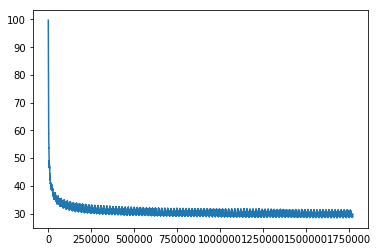

In [7]:
J, params = model.train(data)